<a href="https://colab.research.google.com/github/HARASEON/ML_class/blob/main/Feature_extraction1_Logistic_Regression_ML_Final_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Final Project
###K-NN (K Nearest Neighbor)

Using sklearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##**0. Design**
- Aim of the experiments : building a optimized K-NN model

- Causes of Churn from the bank data
  - It has a labeled sample for training => **Supervised learning**
  - It need to classify into two parts => **Exited = 0 Exited =1**
  - It has 10 Features => **multivariate learning**

## However, It has low performance, we try to use feature extraction.
  

##**1. Data Loading**

- Data loading by pandas module and using read_csv method
- Data spliting into three part, which is train, validation and test sets by using slice function in python


In [ ]:
import io
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sn
import math
from sklearn.preprocessing import RobustScaler
from zlib import crc32
from collections import Counter
from pandas.plotting import scatter_matrix

%matplotlib inline


# Data loading for exploration
# Please input your data path
def data_load_exp(path):
  '''
  # Data loading
  - loading data
  - spliting the three set of data
  - path format 
  ex.
  '/content/drive/My Drive/exam_for_ML/Churn_Modelling_Age.csv' 
  '''
  origin_data = pd.read_csv(path) #skiprows=[0])
  data = pd.DataFrame(origin_data)

  return data

# Data loading for ML
def data_load(path):
  '''
  # Data loading
  - loading data
  - spliting the three set of data 
  - path format 
  ex.
  '/content/drive/My Drive/exam_for_ML/Churn_Modelling_Age.csv' 
  '''
  origin_data = pd.read_csv(path, header=None, skiprows=[0])
  data = pd.DataFrame(origin_data)
  return data

In [ ]:
# Female = 0 Male = 1

X_explor= data_load_exp('/content/drive/My Drive/exam_for_ML/Churn_Modelling_Deleted.csv')
print(X_explor)
# Feature Extraction by "Logistic Regression"
X_exp = X_explor.drop(['CustomerId','Geography_Category1','Geography_Category2','Tenure','CreditScore','EstimatedSalary','Age','NumOfProducts','HasCrCard'], axis=1) 
X_exp

      CustomerId  CreditScore  ...  EstimatedSalary  Exited
0       15787619          844  ...        145936.28       0
1       15770309          656  ...        127014.32       0
2       15569178          570  ...         71811.90       0
3       15795519          716  ...        197322.13       0
4       15621893          727  ...         46941.41       0
...          ...          ...  ...              ...     ...
6378    15621644          678  ...         92934.41       0
6379    15798024          537  ...        186235.98       0
6380    15653251          408  ...        188484.52       1
6381    15764927          753  ...        195563.99       0
6382    15660878          705  ...         34436.83       0

[6383 rows x 14 columns]


,Gender,Age_Category,Balance,IsActiveMember,Exited
0,1,1,160980.03,0,0
1,1,1,151762.74,1,0
2,0,1,82767.42,0,0
3,0,1,128743.80,0,0
4,1,1,133550.67,1,0
...,...,...,...,...,...
6378,1,8,123356.63,1,0
6379,1,8,92242.34,1,0
6380,0,8,87873.39,0,1
6381,1,9,121513.31,1,0


##**2. Data exploration**
First, to figure out how the data distributes, I need to see a t-sne plot. As you can see, the data is hard to be classified.

Second, I wonder that how 'Balance' data look like so that I draw the histogram to see the distribution. However, It has simialr distribution between 'Exited = 0 ' and 'Exited = 1'. It means that balance does not highly influences on factor of the exited rate from the bank.

Third, to find out the correlation with each feature, calculate correlation of each features and drawing the scatter plot. Among 4 features, I used the features that has a high correlation points.


In [ ]:
# First data exploration

from sklearn.manifold import TSNE
X = np.array(X_exp)[:,:-1] # total dataset - label
Y = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

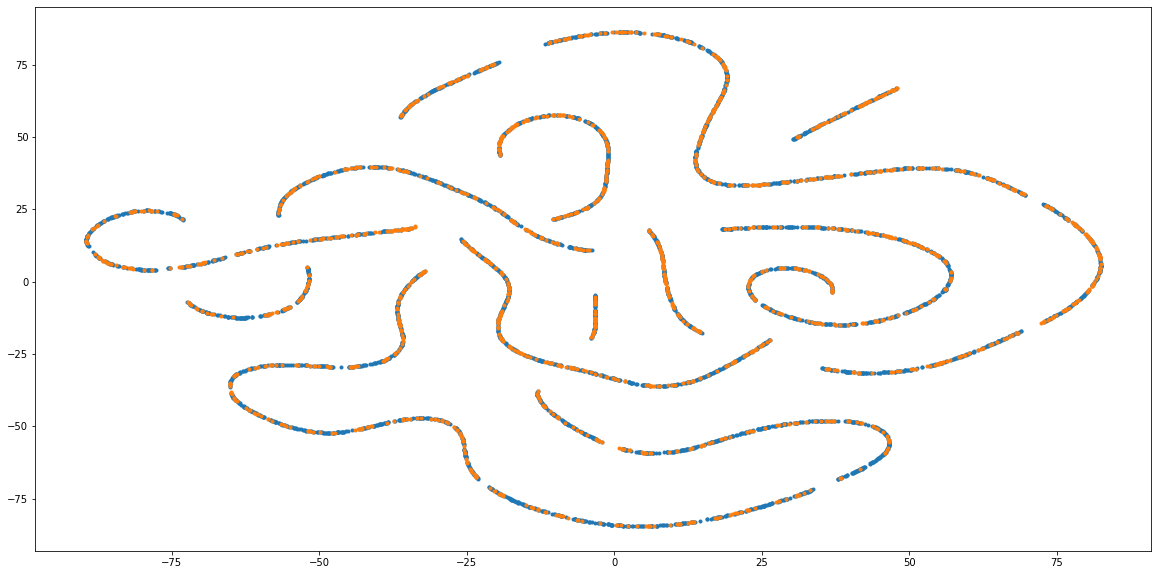

In [ ]:
plt.rcParams['figure.figsize'] = (20,10)
for i in range(2):
  idx = i == X_exp.Exited
  plt.plot(Y[idx,0],Y[idx,1],'.')
plt.show()

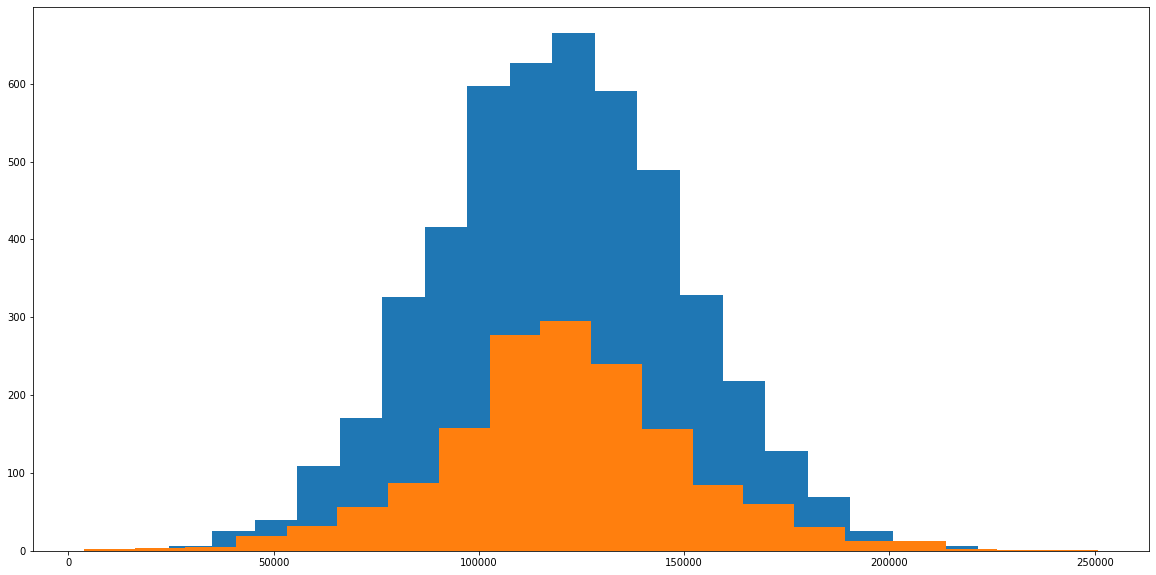

In [ ]:
# Second data exploration

plt.hist(X_explor['Balance'][X_exp.Exited==0],20)
plt.hist(X_explor['Balance'][X_exp.Exited==1],20)
plt.show()

Exited            1.000000
Age_Category      0.291191
Balance           0.017208
Gender           -0.112880
IsActiveMember   -0.171786
Name: Exited, dtype: float64


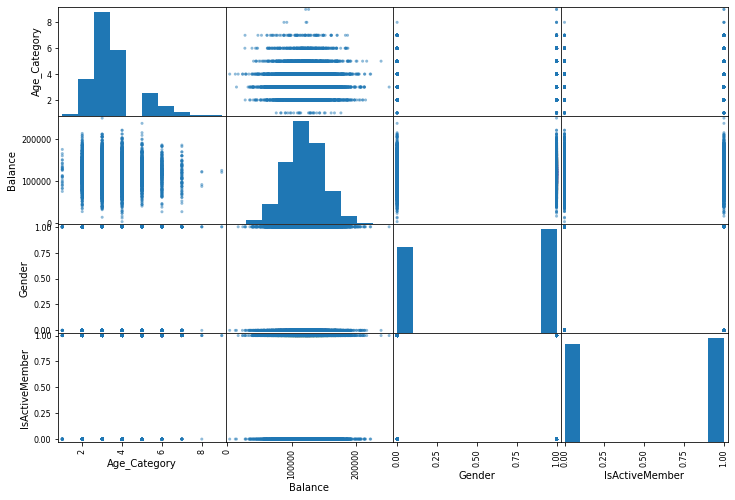

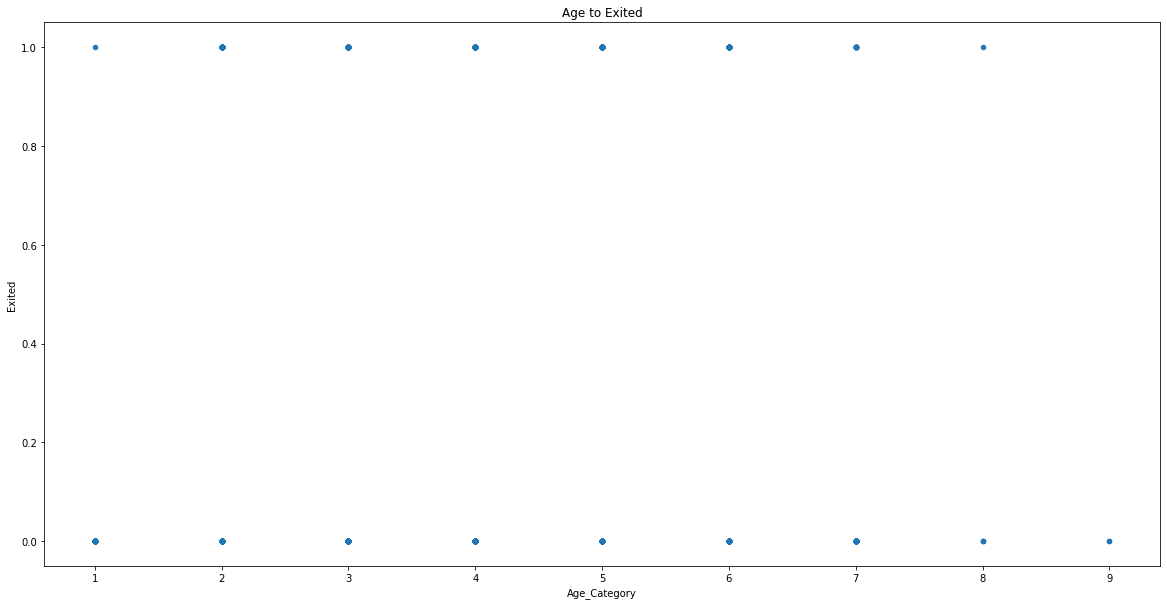

In [ ]:
# Third data exploration
# Correlation (Standard : Balance = 1) 
# From the result, Balance has a deeply related to exited rate.
corr_matrix = X_exp.corr()
print(corr_matrix['Exited'].sort_values(ascending=False)) 

# Show scatter plot matrix
attributes = ['Age_Category', 'Balance', 'Gender', 'IsActiveMember']
scatter_matrix(X_exp[attributes], figsize=(12, 8))

# maginify the "Age to Exited" that has the largest correlation value among other features.
X_exp.plot(title = "Age to Exited", kind = "scatter", x = "Age_Category", y = "Exited")

##**3. Data preprocessing**
1) Data spliting & Label Extraction
1. Shuffling the data 
2. Dividing the data set into three parts.
- train_set: test_set  = 8 : 2
- y_train, y_test = 8 : 2

In [ ]:
# Data spliting
np.random.seed(42)

def split_train_test(data, test_ratio):
  '''
  spliting train set and test set
  '''
  shuffled_indices = np.random.permutation(data)
  test_set_size = int(len(data) * test_ratio)
  # val_set_size = int(len(data) * 0)
  train_indices = shuffled_indices[:test_set_size]
  # val_indices = shuffled_indices[test_set_size:test_set_size + val_set_size]
  test_indices = shuffled_indices[test_set_size:]
  # return train_indices, val_indices, test_indices
  return train_indices, test_indices

train_set, test_set = split_train_test(X_exp, 0.8) # 8:2 = train : test

print(train_set.shape)
print(test_set.shape)

x_train = np.array(train_set[:,:-1])
x_test = np.array(test_set[:,:-1])

(5106, 5)
(1277, 5)


In [ ]:
y_train = train_set[:,-1]
y_test = test_set[:,-1]

print("y_train: ", y_train.shape, y_train)
print("y_test:", y_test.shape, y_test)

y_train:  (5106,) [1. 1. 1. ... 1. 0. 1.]
y_test: (1277,) [0. 0. 0. ... 0. 1. 0.]


##**3. Data preprocessing**
2) Data Scaling

Since the scale will be different for each column of data, it is necessary to go through a normalization process that converts the values of data in numerical form into 0-1.

- Standard scaler : transform all value with mean = 0 and variance 1 
- Z-score standardization : mean = 0, standard deviation = 1 -> standard normal distribution.
To avoid problem related with outlierm, use the strategy of regularization.
- x' = (x - mean)/standard deviation


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline


# Scaling for calculation the distance 

scaler = StandardScaler()
scaler.fit(x_train) 
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#**4. Model Selection/Training**

By Using grid search method three times with F1 score, I could find out the the best K-NN model with the optimal K

* The result is K = 3

In [ ]:
# Grid searching & model fitting
knn_clf_pipe=Pipeline([
      ("knn_clf",KNeighborsClassifier(n_neighbors=9))                                              
  ])

param_grid=dict(knn_clf__n_neighbors=[1,2,3,4,5,6,7,8,9,10]
                )

classifier = GridSearchCV(knn_clf_pipe, param_grid=param_grid,scoring='f1',cv=3,return_train_score=True,refit=True)

classifier.fit(x_train,y_train)
classifier1=classifier.best_params_
classifier2 = classifier.best_estimator_

print(classifier1)
print(classifier2)


{'knn_clf__n_neighbors': 3}
Pipeline(steps=[('knn_clf', KNeighborsClassifier(n_neighbors=3))])


##**5. Model Prediction**


In [ ]:
# Prediction
y_pred = classifier.predict(x_test)
y_pred

array([0., 0., 0., ..., 0., 1., 0.])

##**6. Performance evaluation**
- ACC = (TP + TN)/(TP + TN + FP + FN) = 1 - ERR
- Precesion = TP / (TP + FP)
  - standard : model's prediction 
- Recall = TP/ (TP + FN)
  - standard : data
- F1-score = {2 *(precision * recall)} / (precision + recall)
- confusion matrix


[[847  97]
 [221 112]]


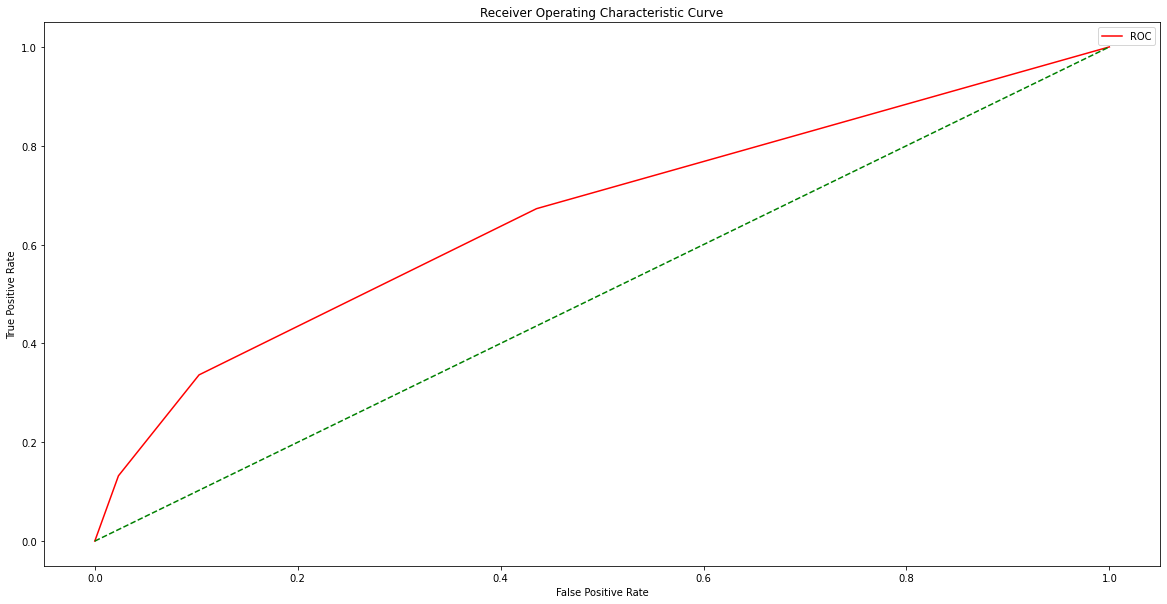

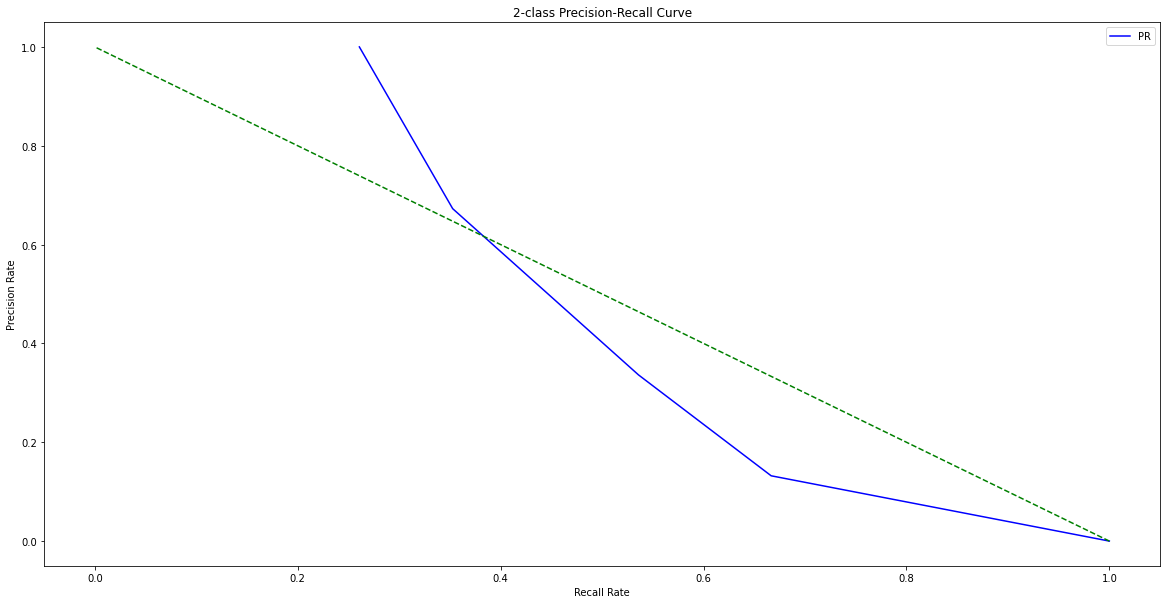

In [ ]:
# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

predict_proba = classifier.predict_proba(x_test)

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

def plot_pr_curve(fper, tper):
    plt.plot(fper, tper, color='blue', label='PR')
    plt.plot([1, 0], [0, 1], color='green', linestyle='--')
    plt.xlabel('Recall Rate')
    plt.ylabel('Precision Rate')
    plt.title('2-class Precision-Recall Curve')
    plt.legend()
    plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, predict_proba[:,1])
fper, tper, thresholds = roc_curve(y_test, predict_proba[:,1])
plt.rcParams['figure.figsize'] = (20,10)
plot_roc_curve(fper, tper)
plot_pr_curve(precision, recall)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import auc
def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Accuracy:{0:.4f}, Recall:{1:.4f}, Precision:{2:.4f}, F1-Score:{3:.4f}'.format(accuracy, recall, precision, f1))

def pr_auc_score(y_test, pred_proba_c1):
    precision, recall, _ = precision_recall_curve(y_test, pred_proba_c1)
    pr_auc = auc(recall, precision)
    return pr_auc

print('roc_score:{0:.4f}'.format(roc_auc_score(y_test, classifier.predict_proba(x_test)[:,1])))
print('pr_auc_score:{0:.4f}'.format(pr_auc_score(y_test, classifier.predict_proba(x_test)[:,1])))
get_clf_eval(y_test, y_pred)

roc_score:0.6602
pr_auc_score:0.4827
Accuracy:0.7510, Recall:0.3363, Precision:0.5359, F1-Score:0.4133


In [ ]:
from sklearn.metrics import confusion_matrix

def make_confusion(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    confusion_df = pd.DataFrame(confusion,columns=['Predicted_Negative','Predicted_Positive'],index=['Actual_Negative','Actual_Positive'])
    return confusion_df

make_confusion(y_test,y_pred)

,Predicted_Negative,Predicted_Positive
Actual_Negative,847,97
Actual_Positive,221,112


# Finding Threshold for the better performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score 

def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Accuracy:{0:.4f}, Recall:{1:.4f}, Precision:{2:.4f}, F1-Score:{3:.4f}'.format(accuracy, recall, precision, f1))


def get_eval_by_threshold(y_test, pred_proba_c1, threshold):
    for custom_threshold in threshold:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('Threshold:',custom_threshold)
        get_clf_eval(y_test, custom_predict)


get_clf_eval(y_test, y_pred)
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
get_eval_by_threshold(y_test, classifier.predict_proba(x_test)[:,1].reshape(-1,1), thresholds)

Accuracy:0.7510, Recall:0.3363, Precision:0.5359, F1-Score:0.4133
Threshold: 0.1
Accuracy:0.5928, Recall:0.6727, Precision:0.3528, F1-Score:0.4628
Threshold: 0.15
Accuracy:0.5928, Recall:0.6727, Precision:0.3528, F1-Score:0.4628
Threshold: 0.2
Accuracy:0.5928, Recall:0.6727, Precision:0.3528, F1-Score:0.4628
Threshold: 0.25
Accuracy:0.5928, Recall:0.6727, Precision:0.3528, F1-Score:0.4628
Threshold: 0.3
Accuracy:0.5928, Recall:0.6727, Precision:0.3528, F1-Score:0.4628
Threshold: 0.35
Accuracy:0.7510, Recall:0.3363, Precision:0.5359, F1-Score:0.4133
Threshold: 0.4
Accuracy:0.7510, Recall:0.3363, Precision:0.5359, F1-Score:0.4133
Threshold: 0.45
Accuracy:0.7510, Recall:0.3363, Precision:0.5359, F1-Score:0.4133
Threshold: 0.5
Accuracy:0.7510, Recall:0.3363, Precision:0.5359, F1-Score:0.4133
